<a href="https://colab.research.google.com/github/anaconda121/CTC/blob/main/CTC_Systematic_Equities_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as plt
from collections import defaultdict
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Systematic Equities Case Study

In [ ]:
emerging_market_countries = ['BRA','MEX','IND','CHN','ZAF']
developed_market_countries = ['USA','JPN','DEU','GBR','FRA']

columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # total data
features = ['Open', 'Close', 'High', 'Low', 'Volume'] # input features to LSTM

In [ ]:
# example of portfolio:
# keys: countries, values: array of five stock tickers.

portfolio = {
            'BRA': ['PBR','VALE','ITUB','NU','BSBR'],
            'MEX': ['AMX','KCDMY','VLRS','ALFAA.MX','BBAJIOO.MX'],
            'IND': ['RELIANCE.NS','TCS', 'HDB', 'INFY', 'ADANIENT.NS'],
            'USA': ['AAPL', 'MSFT','GOOG','AMZN','NVDA']
            }

stock_mapping = {}
for country in portfolio:
    for stock in portfolio[country]:
        stock_mapping[stock] = country

In [ ]:
def get_data(portfolio, start_date, end_date):
    # Initialize an empty DataFrame
    data = pd.DataFrame()

    # Create an empty list for columns
    columns = []

    # Loop through each country in the portfolio
    for country, tickers in portfolio.items():
        # Download data for each ticker
        df = yf.download(tickers, start=start_date, end=end_date)

        # Extract the columns representing stock attributes (e.g., 'Adj Close', 'Volume', etc.)
        stock_attributes = df.columns.levels[0]

        # Extend the list of columns with country and attribute prefix
        country_columns = [(country, attr, ticker) for ticker in tickers for attr in stock_attributes]
        columns.extend(country_columns)

        # Concatenate the data to the main DataFrame
        data = pd.concat([data, df], axis=1)

    # Create a multi-index header
    data.columns = pd.MultiIndex.from_tuples(columns)
    return data

In [ ]:
# sample output from get_data function
data = get_data(portfolio, start_date='2003-01-01', end_date='2023-10-04')
data.interpolate(method = 'linear', inplace = True, limit_direction = 'both')
data

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


BRA                                                          \
           Adj Close     Close   High        Low       Open Volume Adj Close   
                 PBR       PBR    PBR        PBR        PBR    PBR      VALE   
Date                                                                           
2003-01-01  5.718266  0.351957  10.33   0.994022   0.964791  13.01  0.797108   
2003-01-02  5.718266  0.351957  10.33   0.994022   0.964791  13.01  0.797108   
2003-01-03  5.718266  0.361730  10.33   0.994022   0.964791  13.01  0.819241   
2003-01-06  5.718266  0.385359  10.33   1.076309   0.968129  13.01  0.872756   
2003-01-07  5.718266  0.381129  10.33   1.077626   0.973137  13.01  0.863176   
...              ...       ...    ...        ...        ...    ...       ...   
2023-09-27  5.040000  5.216112   7.10  14.940000  12.990000   5.04  5.220000   
2023-09-28  5.090000  5.346015   7.29  14.840000  13.230000   5.09  5.350000   
2023-09-29  5.130000  5.366000   7.25  14.990000  13.400000   5.13  5.370000   
2023-10-02  5.070000  5.300000   7.05  14.680000  13.220000   5.07  5.300000   
2023-10-03  4.940000  5.140000   6.84  14.300000  12.880000   4.94  5.140000   

                                       ...         USA              \
            Close     High        Low  ...        High         Low   
             VALE     VALE       VALE  ...        AMZN        AMZN   
Date                                   ...                           
2003-01-01  10.33   3.7750   2.408333  ...    0.256429    0.959500   
2003-01-02  10.33   3.7750   2.408333  ...    0.256429    0.959500   
2003-01-03  10.33   3.7750   2.408333  ...    0.264286    0.979500   
2003-01-06  10.33   4.0875   2.416667  ...    0.268393    1.020000   
2003-01-07  10.33   4.0925   2.429167  ...    0.264107    1.041500   
...           ...      ...        ...  ...         ...         ...   
2023-09-27   7.10  14.9400  12.990000  ...  172.619995  125.760002   
2023-09-28   7.29  14.8400  13.230000  ...  169.339996  124.040001   
2023-09-29   7.25  14.9900  13.400000  ...  172.020004  128.199997   
2023-10-02   7.05  14.6800  13.220000  ...  171.220001  127.279999   
2023-10-03   6.84  14.3000  12.880000  ...  172.259995  128.059998   

                                                                          \
                  Open      Volume   Adj Close        Close         High   
                  AMZN        AMZN        NVDA         NVDA         NVDA   
Date                                                                       
2003-01-01    2.490664   26.150000    1.000000  181428800.0  129680000.0   
2003-01-02    2.490664   26.150000    1.000000  181428800.0  129680000.0   
2003-01-03    2.490664   26.795000    1.029167  147453600.0  175140000.0   
2003-01-06    2.490664   27.010000    1.050833  390532800.0  153962000.0   
2003-01-07    2.490664   27.459999    1.130833  342344800.0  191364000.0   
...                ...         ...         ...          ...          ...   
2023-09-27  129.440002  312.299988  423.299988   66921800.0   66553400.0   
2023-09-28  130.690002  310.989990  424.600006   56294400.0   54555000.0   
2023-09-29  134.080002  317.750000  438.269989   51814200.0   62377600.0   
2023-10-02  132.154999  316.279999  440.299988   52164500.0   48029700.0   
2023-10-03  134.929993  320.829987  448.079987   49594600.0   51565000.0   

                                                  
                    Low        Open       Volume  
                   NVDA        NVDA         NVDA  
Date                                              
2003-01-01  897427216.0  67025200.0  130254000.0  
2003-01-02  897427216.0  67025200.0  130254000.0  
2003-01-03  897427216.0  55546800.0  103749600.0  
2003-01-06  897427216.0  59456200.0  103342800.0  
2003-01-07  897427216.0  80517400.0  149827200.0  
...                 ...         ...          ...  
2023-09-27   18764200.0  19410100.0   44493500.0  
2023-09-28   18201400.0  19683600.0   42466300.0  
2023-09-29  

<Axes: xlabel='Date'>

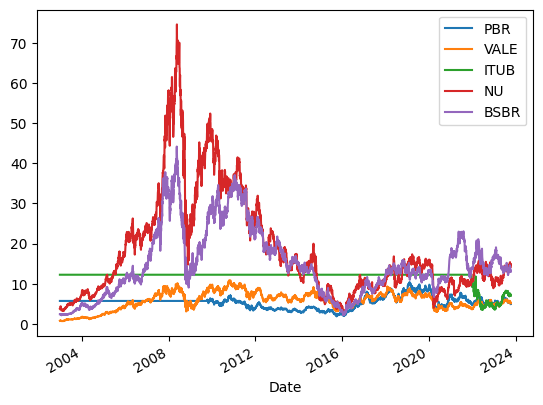

In [ ]:
data["BRA"]["Adj Close"].plot()

In [ ]:
def generate_normalized_individal_equity_data():
    equity_dfs = []
    ticker_list = []

    for country in portfolio:
        for stock in portfolio[country]:
            df = pd.DataFrame(data.index) # initializing default df to have dates from 01-01-2023 -> 10-03-2023
            scaler = MinMaxScaler() # initializing scaler for feature normalization
            ticker_list.append(stock)
            for col in columns:
                col_data = data[country][col][stock].reset_index() # assigning equity data to df
                df[col] = col_data[stock]

            # feature normalization before insertion
            feature_transform = scaler.fit_transform(df[features])
            df_feature_transform = pd.DataFrame(columns = features, data = feature_transform, index = data.index)
            df_feature_transform.insert(len(features), "Adj Close", list(df["Adj Close"]), True) # add in output value to normalized df
            equity_dfs.append(df_feature_transform)

    print(ticker_list)
    return equity_dfs

In [ ]:
normalized_equity_dfs = generate_normalized_individal_equity_data()
normalized_equity_dfs

['PBR', 'VALE', 'ITUB', 'NU', 'BSBR', 'AMX', 'KCDMY', 'VLRS', 'ALFAA.MX', 'BBAJIOO.MX', 'RELIANCE.NS', 'TCS', 'HDB', 'INFY', 'ADANIENT.NS', 'AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA']


[                Open     Close      High       Low    Volume  Adj Close
 Date                                                                   
 2003-01-01  0.005388  0.007007  0.822014  0.005946  0.795853   5.718266
 2003-01-02  0.005388  0.007007  0.822014  0.005946  0.795853   5.718266
 2003-01-03  0.005388  0.008460  0.822014  0.005946  0.795853   5.718266
 2003-01-06  0.005557  0.011974  0.822014  0.009387  0.795853   5.718266
 2003-01-07  0.005810  0.011345  0.822014  0.009442  0.795853   5.718266
 ...              ...       ...       ...       ...       ...        ...
 2023-09-27  0.613752  0.730433  0.443794  0.589153  0.160287   5.040000
 2023-09-28  0.625894  0.749753  0.466042  0.584971  0.164274   5.090000
 2023-09-29  0.634495  0.752725  0.461358  0.591244  0.167464   5.130000
 2023-10-02  0.625388  0.742909  0.437939  0.578280  0.162679   5.070000
 2023-10-03  0.608187  0.719113  0.413349  0.562389  0.152313   4.940000
 
 [5383 rows x 6 columns],
                 Open  

In [ ]:
def generate_train_test_split(ticker):
    multiplication_factor = {"BRA" : 0, "MEX" : 1, "IND" : 2, "USA" : 3}
    country = stock_mapping[ticker]
    equity_list = portfolio[country]
    index = multiplication_factor[country] * len(equity_list) + equity_list.index(ticker)
    equity = normalized_equity_dfs[index]

    X_train, X_test, y_train, y_test = train_test_split(np.array(equity[features]), np.array(equity["Adj Close"]), test_size = 0.2, random_state = 42)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = generate_train_test_split("PBR")

In [ ]:
X_train.shape[1]

5

In [ ]:
def define_model(X_train):
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (1, X_train.shape[1])))

    for i in range(4):
        model.add(Dropout(0.2))
        model.add(LSTM(units = 50, return_sequences = True))

    model.add(Dense(units = 1))
    return model

def training_loop():
    for country in portfolio:
        for stock in portfolio[country]:
            # generating train test split
            X_train, X_test, y_train, y_test = generate_train_test_split(stock)

            X_train_numpy = X_train # saving copy of X_train as numpy array before we reshape for shape definition of LSTM

            # reshaping data for insertion into LSTM
            X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
            X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

            # generating LSTM model architecture
            model = define_model(X_train_numpy)
            model.compile(optimizer = "adam", loss = "mean_squared_error")

            # starting training loop for LSTM model trained on data for a single equity
            print("Fitting LSTM model for {} equity".format(stock))
            history = model.fit(X_train, y_train,epochs = 100, batch_size = 32)

            # saving model for future predictions
            model.save("/content/drive/My Drive/Cornell/CTC/SysEq/LSTM_{}".format(stock))

In [ ]:
training_loop()

Fitting LSTM model for PBR equity
Epoch 1/100
135/135 [==============================] - 12s 8ms/step - loss: 12.4266
Epoch 2/100
135/135 [==============================] - 1s 8ms/step - loss: 2.2750
Epoch 3/100
135/135 [==============================] - 1s 9ms/step - loss: 2.2145
Epoch 4/100
135/135 [==============================] - 1s 9ms/step - loss: 2.2013
Epoch 5/100
135/135 [==============================] - 1s 9ms/step - loss: 2.1807
Epoch 6/100
135/135 [==============================] - 1s 8ms/step - loss: 2.1775
Epoch 7/100
135/135 [==============================] - 1s 8ms/step - loss: 2.1667
Epoch 8/100
135/135 [==============================] - 2s 13ms/step - loss: 2.1600
Epoch 9/100
135/135 [==============================] - 2s 13ms/step - loss: 2.1666
Epoch 10/100
135/135 [==============================] - 2s 12ms/step - loss: 2.1608
Epoch 11/100
135/135 [==============================] - 1s 9ms/step - loss: 2.1630
Epoch 12/100
135/135 [==============================] - 1

In [ ]:
'''
Overview: the following function is a very simple (albeit stupid) trading strategy where
if the log returns are negative we short the stock and if the log returns are positive
we long the returns. We do an equal weightage across all the stocks for simplicity.

Input:
portfolio: a dictionary of the same format provided above.
start_date: 'year-month-day'
end_date : 'year-month-day'

Return: a data frame where the indeces are dates (only trading days) between
the start-date and end-date provided above. For a given date (i.e a row) the following
two conditions must hold:

1. The absolute value of the holdings sum to 1.
2. The value of the holdings sum to 0 (i.e long/short across the entire portfolio).
'''
def simple_strat(portfolio, start_date, end_date):
    data = get_data(portfolio,start_date = start_date, end_date = end_date)
    trading_list = pd.DataFrame(columns = data.columns.levels[2])
    for country in data.columns.levels[0]:
        for ticker in  data[country]['Adj Close'].columns:
            returns = (data[country]['Adj Close'][ticker])
            log_returns = (returns / returns.shift(1)).apply(lambda x: np.log(x))
            ticker_trades = pd.DataFrame(columns = [ticker])
            for date in log_returns.index:
                if (log_returns[date] > 0):
                    ticker_trades.loc[date] = 1
                else:
                    ticker_trades.loc[date] = -1
            trading_list[ticker] = ticker_trades
    trading_list_one = trading_list.sub(trading_list.mean(axis=1), axis=0)
    trading_list_normalized = trading_list_one.div(trading_list_one.abs().sum(axis=1), axis=0)
    return trading_list_normalized


In [ ]:
# this is what the output to our trading strategy looks like
trading_list = simple_strat(portfolio, start_date='2015-01-01',end_date='2023-01-01')
trading_list.head(5)

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778
2015-01-05,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-06,0.083333,-0.035714,0.083333,0.083333,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,0.083333,-0.035714
2015-01-07,0.035714,0.035714,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,0.035714,-0.083333,0.035714,-0.083333,0.035714,0.035714,-0.083333


In [ ]:
'''
Given a trading list check to see if the portfolio weights sum to 0 and if the
 absolute value of the weights sum to 1.
'''

def check_long_short(trading_list):
    vals = trading_list.sum(axis = 1)
    abs_vals = trading_list.abs().sum(axis = 1)
    def is_close_to_zero(value, threshold=1e-6):
        return abs(value) <= threshold

    def is_close_to_one(value, threshold=(1+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result = vals.apply(lambda x: is_close_to_zero(x))
    result_ones = abs_vals.apply(lambda x: is_close_to_one(x))
    # Check if all values are close to 0
    all_close_to_zero = result.all()
    # Check if all values are close to 1
    all_close_to_one= result_ones.all()
    return all_close_to_zero, all_close_to_one

In [ ]:
check_long_short(trading_list)

(True, True)

In [ ]:
'''
check to see if the daily turn over is less than the treshold (0.25)
'''
def check_turn_over(trading_list, treshold):
    abs_turn_over = trading_list.diff().abs().sum(axis = 1)

    def is_close_to_turnover(value, threshold=(treshold+1e-6)):
        return abs(value) <= threshold

    # Apply the function to all elements in the Series
    result_turnover = abs_turn_over.apply(lambda x: is_close_to_turnover(x))
    # Check if all values are close to 0
    all_close_to_turnover= result_turnover.all()
    return all_close_to_turnover


In [ ]:
check_turn_over(trading_list, 0.25)

False

In [ ]:
trading_list

,AAPL,ADANIENT.NS,ALFAA.MX,AMX,AMZN,BBAJIOO.MX,BSBR,GOOG,HDB,INFY,ITUB,KCDMY,MSFT,NU,NVDA,PBR,RELIANCE.NS,TCS,VALE,VLRS
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,0.250000,-0.027778,-0.027778,-0.027778
2015-01-05,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,-0.026316,0.500000,-0.026316,-0.026316,-0.026316
2015-01-06,0.083333,-0.035714,0.083333,0.083333,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,-0.035714,0.083333,-0.035714,-0.035714,0.083333,-0.035714
2015-01-07,0.035714,0.035714,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,-0.083333,0.035714,0.035714,0.035714,-0.083333,0.035714,-0.083333,0.035714,0.035714,-0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,0.166667
2022-12-27,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,-0.029412,0.166667,-0.029412,-0.029412,-0.029412
2022-12-28,-0.041667,-0.041667,-0.041667,-0.041667,-0.041667,-0.041667,0.062500,-0.041667,0.062500,0.062500,0.062500,-0.041667,-0.041667,0.062500,-0.041667,0.062500,0.062500,-0.041667,0.062500,-0.041667
2022-12-29,0.035714,-0.083333,0.035714,0.035714,0.035714,-0.083333,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,-0.083333,0.035714,-0.083333,0.035714,0.035714,-0.083333,-0.083333


trading_list

1000

APPL: 0.5 (50)   --> $500   AMZN: -0.5 (50) --> $-500
APPL: 0.3  (60) -->     AMZN: 0.7 (30) -->

200/60 -> 3.333, -> 33.333
1000
APPL:
0.2               1.2



P = 1000
[APPL, AMZN, GOOG, TSLA]
DAY 1: [0.25,0.25,-0.25,-0.25]
APPL: 50, AMZN: 20, GOOG: 30, TSLA: 40
5, 12.5, 8.33, 6.25

DAY 2: [0.3,0.2,-0.4,-0.1]
APPL: 60, : 10, GOOG: 50, TSLA: 40
APPL: 5+50/60(300), 12.5





In [ ]:
'''
Overview: given a trading list of portfolio holdings use yfinance to find the
overall pnl.

# check PNL is not negative

# if you loose all your money your done
# make sure all dates are within bounds
# make sure dates are every day
# make sure dates are order
# make sure weights sum to 0 and absolute value to 1
#
#weights after closing day
'''


def backtest(trading_list: pd.DataFrame,x_list, y_list) -> None:
   check_date(trading_list)
   check_weights(trading_list)
   check_pnl(trading_list,x_list, y_list)


   # new_list = trading_list.copy(deep=True)
   # new_row = {'AAPL': 1, 'GOOG': np.nan}
   # new_list.loc["1"] = new_row
   # check_date(new_list)
   # new_list.loc[pd.to_datetime("2023-01-01")] = new_row
   # check_weights(new_list)
   # check_date(new_list)
# "will be sent in two days"

def check_weights(trading_list: pd.DataFrame) -> None:
   assert (trading_list.isna().all(axis=1) | trading_list.notna().all(axis=1)).all(), "There is a row with some, but not all NaN values"

   row_sums = abs(trading_list.sum(axis=1)) < 1e-5
   assert row_sums.all(), "Weights do not add up to zero"

   row_sums_abs = abs(trading_list.abs().sum(axis=1)) - 1 < 1e-5
   assert row_sums_abs.all(), "Absolute values of weights do not add up to one"

def calculate_money(index, holdings, values):
   if holdings == {}:
      return sum(values.values())
   value = 0
   for stock in holdings:
      num_stock = holdings[stock]
      country = stock_mapping[stock]
      stock_value_eod = data[country]['Adj Close'].loc[index][stock]
      if math.isnan(stock_value_eod):
         value += values[stock]
      else:
         value += num_stock*stock_value_eod
   return value

# Make Sure PNL is not negative and if at any moment your money is 0, you are done.
def check_pnl(trading_list: pd.DataFrame,x_list, y_list) -> None:
   stock_holdings = defaultdict(float)
   stock_holdings_values = defaultdict(float)
   for stock in stock_mapping:
      stock_holdings_values[stock] = 100000/len(stock_mapping)

   for cur_day, row in trading_list.iterrows():
      if row.isna().all():
         continue

      cur_money = calculate_money(cur_day, stock_holdings,stock_holdings_values) # sold everything
      build = 0
      for stock, weight in row.items():
         num_stocks_value = cur_money * weight
         country = stock_mapping[stock]
         stock_value_eod = data[country]['Adj Close'].loc[cur_day][stock]
         if weight < 0:
            stock_holdings[stock] = num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = num_stocks_value
         else:
            stock_holdings[stock] = 3*num_stocks_value / stock_value_eod if not math.isnan(stock_value_eod) else stock_holdings[stock]
            stock_holdings_values[stock] = 3*num_stocks_value

         build += stock_holdings_values[stock]
      x_list.append(cur_day)
      y_list.append(build)
      assert build > 0 , "you lost all your money"

def check_date(trading_list: pd.DataFrame) -> None:
   assert all(isinstance(idx, pd.Timestamp) for idx in trading_list.index), "An index is not a datetime object"

   start_date = pd.to_datetime('2015-01-01')
   end_date = pd.to_datetime('2023-01-01')
   all_within_timeframe = (trading_list.index >= start_date) & (trading_list.index <= end_date)
   assert all(all_within_timeframe), "You have elements outside of the date range"

   assert len(set(trading_list.index)) == len(trading_list.index), "Cannot have rows with duplicate dates"

   assert len(data.index) == len(trading_list.index), "Need to cover all days"

   assert list(trading_list.index) == list(data.index), "Rows must be in order"


In [ ]:
time_stamps = []
pnl_on_day = []
backtest(trading_list,time_stamps,pnl_on_day)

Text(0, 0.5, 'PNL')

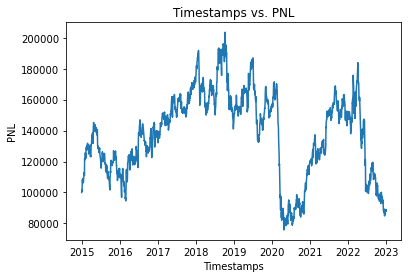

In [ ]:

plt.plot(time_stamps,pnl_on_day)
plt.title('Timestamps vs. PNL')
plt.xlabel('Timestamps')
plt.ylabel('PNL')